- Tworzenie podzbiorów z oryginalnego zbioru danych w celu łatwiejszego przetwarzania
- Zbadanie rozkładu ocen i ilości ocen w zależności od użytkowników i przepisów

# Import

In [1]:
import pandas as pd
import datetime
from isoduration import parse_duration
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import StratifiedKFold

# Constants

## Loading:

In [7]:
REVIEWS_DATA = "../Data/dataset/reviews.parquet"
RECIPES_DATA = "../Data/dataset/recipes.parquet"

## Saving:

In [8]:
REVIEWS_DESC = "../Data/dataset/reviews_desc.txt"
RECIPES_DESC = "../Data/dataset/recipes_desc.txt"

In [9]:
RECIPES_BASE = "../Data/base/recipes_base.parquet"
RECIPES_BASE_DESC = "../Data/base/recipes_base_desc.txt"

RECIPES_TIME = "../Data/base/recipes_time.parquet"
RECIPES_TIME_DESC = "../Data/base/recipes_time_desc.txt"

RECIPES_WEB = "../Data/base/recipes_web.parquet"
RECIPES_WEB_DESC = "../Data/base/recipes_web_desc.txt"

RECIPES_NUTRITIONS = "../Data/base/recipes_nutritions.parquet"
RECIPES_NUTRITIONS_DESC = "../Data/base/recipes_nutritions_desc.txt"

RECIPES_DESCRIPTIVE = "../Data/base/recipes_descriptive.parquet"
RECIPES_DESCRIPTIVE_DESC = "../Data/base/recipes_descriptive_desc.txt"

In [10]:
RECIPE_ID_TO_NAME = "../Data/index/recipe_id_to_name.obj"
RECIPE_ID_TO_INGREDIENTS = "../Data/index/recipe_id_to_ingredients.obj"
RECIPE_ID_TO_CAT = "../Data/index/recipe_id_to_category.obj"
RECIPE_ID_TO_KEYWORDS = "../Data/index/recipe_id_to_keywords.obj"

INDEX_TO_RECIPE_OBJ = "../Data/index/index_to_recipe.obj"
RECIPE_TO_INDEX_OBJ = "../Data/index/recipe_to_index.obj"

In [11]:
RATINGS_BASE = "../Data/base/ratings_base.parquet"
RATINGS_BASE_DESC = "../Data/base/ratings_base_desc.txt"

RATINGS_TIME = "../Data/base/ratings_time.parquet"
RATINGS_TIME_DESC = "../Data/base/ratings_time_desc.txt"

In [12]:
AVG_RATING_PER_RECIPE = "../Data/base/avg_ratings_per_recipe.parquet"
AVG_RATING_PER_USER = "../Data/base/avg_ratings_per_user.parquet"

RATINGS_COUNT_PER_RECIPE = "../Data/base/ratings_per_recipe.parquet"
RATIGNS_COUNT_PER_USER = "../Data/base/ratings_per_user.parquet"

In [13]:
def write_dataframe_info(df, filepath, check_unique=[]):
    f = open(filepath, "w")
    f.write(f"Shape: {str(df.shape)}\n")
    f.write(str(df.dtypes) + "\n")
    for col_name in check_unique:
        f.write(f"{col_name}: {df[col_name].nunique()}\n")
    f.close()

# Load data

## Ratings

Wczytanie oryginalnych danych dotyczących ocen i zapisanie podsumowania do pliku REVIEWS_DESC

In [14]:
ratings = pd.read_parquet(REVIEWS_DATA)
# write_dataframe_info(ratings, REVIEWS_DESC, check_unique=["AuthorId", "RecipeId"])
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1401982 entries, 0 to 1401981
Data columns (total 8 columns):
 #   Column         Non-Null Count    Dtype              
---  ------         --------------    -----              
 0   ReviewId       1401982 non-null  int32              
 1   RecipeId       1401982 non-null  int32              
 2   AuthorId       1401982 non-null  int32              
 3   AuthorName     1401982 non-null  object             
 4   Rating         1401982 non-null  int32              
 5   Review         1401982 non-null  object             
 6   DateSubmitted  1401982 non-null  datetime64[ns, UTC]
 7   DateModified   1401982 non-null  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](2), int32(4), object(2)
memory usage: 64.2+ MB


## Recipes

Wczytanie oryginalnych danych dotyczących przepisów i zapisanie podsumowania do pliku RECIPES_DESC

In [15]:
recipes = pd.read_parquet(RECIPES_DATA)
# write_dataframe_info(recipes, RECIPES_DESC)
recipes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522517 entries, 0 to 522516
Data columns (total 28 columns):
 #   Column                      Non-Null Count   Dtype              
---  ------                      --------------   -----              
 0   RecipeId                    522517 non-null  float64            
 1   Name                        522517 non-null  object             
 2   AuthorId                    522517 non-null  int32              
 3   AuthorName                  522517 non-null  object             
 4   CookTime                    439972 non-null  object             
 5   PrepTime                    522517 non-null  object             
 6   TotalTime                   522517 non-null  object             
 7   DatePublished               522517 non-null  datetime64[ns, UTC]
 8   Description                 522512 non-null  object             
 9   Images                      522516 non-null  object             
 10  RecipeCategory              521766 non-null 

### Fill missing values

In [16]:
recipes["CookTime"].fillna("PT0M", inplace=True)
recipes["PrepTime"].fillna("PT0M", inplace=True)
recipes["TotalTime"].fillna("PT0M", inplace=True)

# Create recipes subsets


In [17]:
def duration_to_minutes(duration):
    return float((duration.date.days * 1440) + (duration.time.hours * 60) + duration.time.minutes)

## Base

RecipeId, Name

In [18]:
recipes_base = recipes[["RecipeId", "Name"]].copy()
# write_dataframe_info(recipes_base, RECIPES_BASE_DESC)

# recipes_base.to_parquet(RECIPES_BASE)

## Time

RecipeId, CookTimeInMinutes, PrepTimeInMinutes, TotalTimeInMinutes

In [19]:
recipes_time = pd.DataFrame()
recipes_time["RecipeId"] = recipes["RecipeId"].copy()
recipes_time["CookTimeInMinutes"] = recipes["CookTime"].copy()
recipes_time["CookTimeInMinutes"] = recipes_time["CookTimeInMinutes"].apply(lambda x: duration_to_minutes(parse_duration(x)))
recipes_time["PrepTimeInMinutes"] = recipes["PrepTime"].copy()
recipes_time["PrepTimeInMinutes"] = recipes_time["PrepTimeInMinutes"].apply(lambda x: duration_to_minutes(parse_duration(x)))
recipes_time["TotalTimeInMinutes"] = recipes["TotalTime"].copy()
recipes_time["TotalTimeInMinutes"] = recipes_time["TotalTimeInMinutes"].apply(lambda x: duration_to_minutes(parse_duration(x)))  

# write_dataframe_info(recipes_time, RECIPES_TIME_DESC)
# recipes_time.to_parquet(RECIPES_TIME)

## Website info

RecipeId, Description, Images, RecipeIngredientQuantities, RecipeServings, RecipeYield, RecipeInstructions

In [20]:
recipes_web_info = recipes[["RecipeId", "Description", "Images", "RecipeIngredientQuantities", "RecipeServings", "RecipeYield", "RecipeInstructions"]].copy()

# write_dataframe_info(recipes_web_info, RECIPES_WEB_DESC)
# recipes_web_info.to_parquet(RECIPES_WEB)

## Nutritions

RecipeId, FatContent, SaturatedFatContent, CholesterolContent, SodiumContent, CarbohydrateContent, FiberContent, SugarContent, ProteinContent

In [21]:
recipes_nutritions = pd.DataFrame()
recipes_nutritions[['RecipeId', 'FatContent', 'SaturatedFatContent', 'CholesterolContent', 'SodiumContent', 'CarbohydrateContent', 'FiberContent', 'SugarContent', 'ProteinContent']] = recipes[['RecipeId', 'FatContent', 'SaturatedFatContent', 'CholesterolContent', 'SodiumContent', 'CarbohydrateContent', 'FiberContent', 'SugarContent', 'ProteinContent']].copy()


# write_dataframe_info(recipes_nutritions, RECIPES_NUTRITIONS_DESC)
# recipes_nutritions.to_parquet(RECIPES_DESC)

## Descriptive columns

RecipeId, RecipeCategory, Keywords, Ingredients

In [22]:
recipes_desc = pd.DataFrame()
recipes_desc["RecipeId"] = recipes["RecipeId"].copy()
recipes_desc["RecipeCategory"] = recipes["RecipeCategory"].copy()

recipes_desc["Keywords"] = recipes["Keywords"].copy()
recipes_desc["Keywords"] = recipes_desc["Keywords"].apply(lambda x: x.tolist())

recipes_desc["Ingredients"] = recipes["RecipeIngredientParts"].copy()
recipes_desc["Ingredients"] = recipes_desc["Ingredients"].apply(lambda x: x.tolist())

# write_dataframe_info(recipes_desc, RECIPES_DESCRIPTIVE_DESC)
# recipes_desc.to_parquet(RECIPES_DESCRIPTIVE)

## Create <i>index_to_recipe</i> and <i>recipe_to_index</i>

In [23]:
def create_index_to_col_dict(df, col_name):
    index_to_col_df = pd.DataFrame(df[col_name])
    col_to_index_df = index_to_col_df.reset_index(inplace=False)
    
    col_to_index_df.set_index(col_name, inplace=True)
    
    temp = index_to_col_df.to_dict('index')
    index_to_col = {key: value[col_name] for key, value in temp.items()}
    
    temp = col_to_index_df.to_dict('index')
    col_to_index = {key: value['index'] for key, value in temp.items()}
    
    return index_to_col, col_to_index

In [24]:
def create_col1_to_col2_dict(df, col_name_1, col_name_2):
    col1_to_col2_df = pd.DataFrame(df[[col_name_1, col_name_2]])
    col1_to_col2_df = col1_to_col2_df.reset_index(inplace=False)
    col1_to_col2_df.set_index(col_name_1, inplace=True)
    col1_to_col2_df.drop(columns=['index'], inplace=True)

    temp = col1_to_col2_df.to_dict('index')
    col1_to_col2 = {key: value[col_name_2] for key, value in temp.items()}
    
    return col1_to_col2

### Index to recipe
    
    Key:   index
    Value: RecipeId
    
### Recipe to index
    
    Key:   RecipeId
    Value: index

In [25]:
index_to_recipe_id, recipe_id_to_index = create_index_to_col_dict(recipes_base, "RecipeId")

### Recipe to name
    Key:   RecipeId
    Value: Name

In [26]:
recipe_id_to_name = create_col1_to_col2_dict(recipes_base, "RecipeId", "Name")

### Recipe to category

    Key:   RecipeId
    Value: RecipeCategory

In [27]:
recipe_id_to_cat = create_col1_to_col2_dict(recipes_desc, "RecipeId", 'RecipeCategory')

### Recipe to ingredients

    Key:   RecipeId
    Value: Ingredients

In [28]:
recipe_id_to_ingredients = create_col1_to_col2_dict(recipes_desc, "RecipeId", 'Ingredients')

### Recipe to keywords

    Key:   RecipeId
    Value: Keywords

In [29]:
recipe_id_to_keywords = create_col1_to_col2_dict(recipes_desc, "RecipeId", 'Keywords')

In [39]:
ratings_sub = sampling.get_ratings_with_min_number_list(ratings, [20,10])

In [41]:
recipes_sub = recipes_base.merge(recipes_desc, on='RecipeId')
recipes_sub = recipes_sub.merge(recipes_web_info, on='RecipeId')

In [43]:
recipes_sub = recipes_sub[recipes_sub.RecipeId.isin(ratings_sub.RecipeId)]

In [44]:
recipes_sub.to_parquet('G:/Recipes/recipes.parquet')

In [49]:
ratings_sub[ratings_sub.AuthorId==2695]

,ReviewId,RecipeId,AuthorId,AuthorName,Rating,Review,DateSubmitted,DateModified
153,236,4807,2695,Hungarian Gypsy,2,"I'm sorry, but I tried this method for my Chri...",2000-12-27 13:47:50+00:00,2000-12-27 13:47:50+00:00
228,335,12134,2695,Hungarian Gypsy,5,This dish was excellent. The sauce turned out...,2001-01-19 16:40:14+00:00,2001-01-19 16:40:14+00:00
40021,45058,55394,2695,Hungarian Gypsy,5,I liked the addition of parsnips and mustard. ...,2003-03-15 14:53:49+00:00,2003-03-15 14:53:49+00:00
177935,190523,86623,2695,Hungarian Gypsy,2,A bit too dry for our tastes.,2007-01-31 11:30:50+00:00,2007-01-31 11:30:50+00:00
182211,195458,53767,2695,Hungarian Gypsy,5,This soup was very easy to make and tasted fan...,2005-08-13 09:49:33+00:00,2005-08-13 09:49:33+00:00
216194,231561,41685,2695,Hungarian Gypsy,4,"This was very good, and easy. I added some ch...",2005-12-24 07:19:11+00:00,2005-12-24 07:19:11+00:00
217136,232543,83287,2695,Hungarian Gypsy,1,Tried this with our leftover ham bone from the...,2005-12-27 16:01:03+00:00,2005-12-27 16:01:03+00:00
222835,238604,51235,2695,Hungarian Gypsy,5,Very tasty and simple. Nothing beats a side d...,2006-01-14 17:42:10+00:00,2006-01-14 17:42:10+00:00
247758,265358,109295,2695,Hungarian Gypsy,5,"This sounds odd, but I'm telling you it is fan...",2006-04-16 17:35:16+00:00,2006-04-16 17:35:16+00:00
294170,314250,37638,2695,Hungarian Gypsy,4,loved it . . . i did add several fresh chopped...,2006-09-20 09:23:01+00:00,2006-09-20 09:23:01+00:00


### Save

In [25]:
# with open(INDEX_TO_RECIPE_OBJ, 'wb') as pickle_file:
#      pickle.dump(index_to_recipe, pickle_file)
        
# with open(RECIPE_TO_INDEX_OBJ, 'wb') as pickle_file:
#      pickle.dump(recipe_to_index, pickle_file)
        
# with open(RECIPE_ID_TO_NAME, 'wb') as pickle_file:
#      pickle.dump(recipe_id_to_name, pickle_file)
# with open(RECIPE_ID_TO_CAT, 'wb') as pickle_file:
#      pickle.dump(recipe_id_to_cat, pickle_file)
# with open(RECIPE_ID_TO_INGREDIENTS, 'wb') as pickle_file:
#      pickle.dump(recipe_id_to_ing, pickle_file)
# with open(RECIPE_ID_TO_KEYWORDS, 'wb') as pickle_file:
#      pickle.dump(recipe_id_to_keywords, pickle_file)

# Create ratings subset

In [26]:
# delete ratings of missing recipes
missing_recipes = ratings[~ratings.RecipeId.isin(recipes.RecipeId)]
ratings = ratings.drop(missing_recipes.index)

In [27]:
print(f"Ratings with missing recipes: {missing_recipes.shape[0]}")
print(f"Missing recipes: {missing_recipes.RecipeId.nunique()}")

Ratings with missing recipes: 19
Missing recipes: 4


In [28]:
print('Number of reviewed recipes: ', ratings['RecipeId'].nunique())
print('Number of users: ', ratings['AuthorId'].nunique())

Number of reviewed recipes:  271674
Number of users:  271906


## Base

RecipeId, AuthorId, Rating

In [29]:
ratings_base = pd.DataFrame()
ratings_base = ratings[['RecipeId', 'AuthorId', 'Rating']].copy()

In [30]:
# ratings_base.to_parquet(RATINGS_BASE)
# write_dataframe_info(ratings_base, RATINGS_BASE_DESC)

## Ratings time

RecipeId, AuthorId, Rating, DateSubmitted

In [31]:
ratings_time = pd.DataFrame()
ratings_time = ratings[['RecipeId', 'AuthorId', 'Rating', 'DateSubmitted']].copy()

In [32]:
# ratings_time.to_parquet(RATINGS_TIME)
# write_dataframe_info(ratings_time, RATINGS_TIME_DESC)

## Average rating

In [33]:
def avg_rating(df, per_col, value):
    return df[(df[per_col]==value) & (df['Rating']!=0)]['Rating'].mean()

In [34]:
avg_ratings_per_user = ratings_base.groupby('AuthorId').mean().drop(columns='RecipeId')
avg_ratings_per_user = avg_ratings_per_user.rename(columns={'Rating': "AvgRating"})
avg_ratings_per_user = avg_ratings_per_user.sort_values(by='AvgRating', ascending=False)

avg_ratings_per_recipe = ratings_base.groupby('RecipeId').mean().drop(columns='AuthorId')
avg_ratings_per_recipe = avg_ratings_per_recipe.rename(columns={'Rating': "AvgRating"})
avg_ratings_per_recipe = avg_ratings_per_recipe.sort_values(by='AvgRating', ascending=False)

In [35]:
# avg_ratings_per_recipe.to_parquet(AVG_RATING_PER_RECIPE)
# avg_ratings_per_user.to_parquet(AVG_RATING_PER_USER)

## Rating count

In [36]:
ratings_per_user = ratings_base.groupby('AuthorId').count().drop(columns='RecipeId')
ratings_per_user = ratings_per_user.rename(columns={'Rating': "Count"})
ratings_per_user = ratings_per_user.sort_values(by="Count", ascending=False)

ratings_per_recipe = ratings_base.groupby('RecipeId').count().drop(columns='AuthorId')
ratings_per_recipe = ratings_per_recipe.rename(columns={'Rating': "Count"})
ratings_per_recipe = ratings_per_recipe.sort_values(by="Count", ascending=False)

### Users min 20 ratings

In [37]:
users_min_20 = ratings_per_user[ratings_per_user.Count >= 20]
ratings_users_min_20 = ratings_base[ratings_base.AuthorId.isin(users_min_20.index)]
recipes_rated_by_users = ratings_users_min_20.RecipeId.unique()
print(f"Użytkownicy, którzy mają 20 ocen stanowią {users_min_20.shape[0]/ratings_per_user.shape[0]*100}% wszystkich użytkowników")
print(f"Stanowią {ratings_users_min_20.shape[0]/ratings_base.shape[0]*100}% wszystkich ocen")
print(f"Ocenili {recipes_rated_by_users.shape[0]} przepisów")

Użytkownicy, którzy mają 20 ocen stanowią 3.0205291534574448% wszystkich użytkowników
Stanowią 65.26555979009431% wszystkich ocen
Ocenili 234693 przepisów


### Recipes min 20 ratings

In [38]:
recipes_min_20 = ratings_per_recipe[ratings_per_recipe.Count >= 20]
ratings_recipes_min_20 = ratings_base[ratings_base.RecipeId.isin(recipes_min_20.index)]
recipes_rated_by_users = ratings_recipes_min_20.AuthorId.unique()
print(f"Przepisy, które mają 20 ocen stanowią {recipes_min_20.shape[0]/ratings_per_recipe.shape[0]*100}% wszystkich przepisow")
print(f"Stanowią {ratings_recipes_min_20.shape[0]/ratings_base.shape[0]*100}% wszystkich ocen")
print(f"Są ocenione przez {recipes_rated_by_users.shape[0]} użytkowników")

Przepisy, które mają 20 ocen stanowią 3.7942534066565075% wszystkich przepisow
Stanowią 40.40620187551312% wszystkich ocen
Są ocenione przez 159553 użytkowników


### Most 25k rated recipes

In [39]:
top25 = ratings_per_recipe[:25000]

In [40]:
ratings_recipes_top25 = ratings_base[ratings_base.RecipeId.isin(top25.index)]

In [41]:
print(f"Top25 najczęsciej ocenianych przepisów to {ratings_recipes_top25.shape[0]/ratings_base.shape[0]*100}% wszystkich ocen")

Top25 najczęsciej ocenianych przepisów to 54.62975841730488% wszystkich ocen


## Create recipes with ratings sample 

In [42]:
recipes_with_ratings = recipes_base[recipes_base.RecipeId.isin(ratings_base.RecipeId)]

In [43]:
index_to_recipes_with_ratings, recipes_with_ratings_to_index = create_index_to_col_dict(recipes_with_ratings, "RecipeId")

# Histograms

## Liczba ocen

In [45]:
ratings = ratings_base[ratings_base.Rating>0].copy()

In [46]:
ratings_0 = ratings_base[ratings_base.Rating==0][:15000].copy()

In [47]:
ratings_hist = ratings.append(ratings_0)

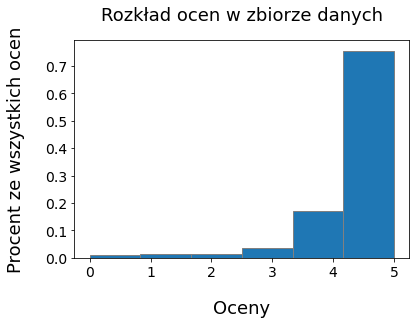

In [55]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.rcParams['axes.titlepad'] = 20

data = list(ratings_hist['Rating'])

plt.hist(data, bins=6, edgecolor='gray', weights=np.ones_like(data) / len(data))
plt.xlabel("Oceny", fontsize=18, labelpad=20)
plt.ylabel("Procent ze wszystkich ocen", fontsize=18, labelpad=20)
plt.title("Rozkład ocen w zbiorze danych", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

# fig.savefig('G:/Recipes/Wykresy/ratings_value_counts_1.png', dpi=100)

## Liczba ocen / użytkownik

In [57]:
y = list(ratings_per_user['Count'])[:5000]
ids = range(0, len(y))

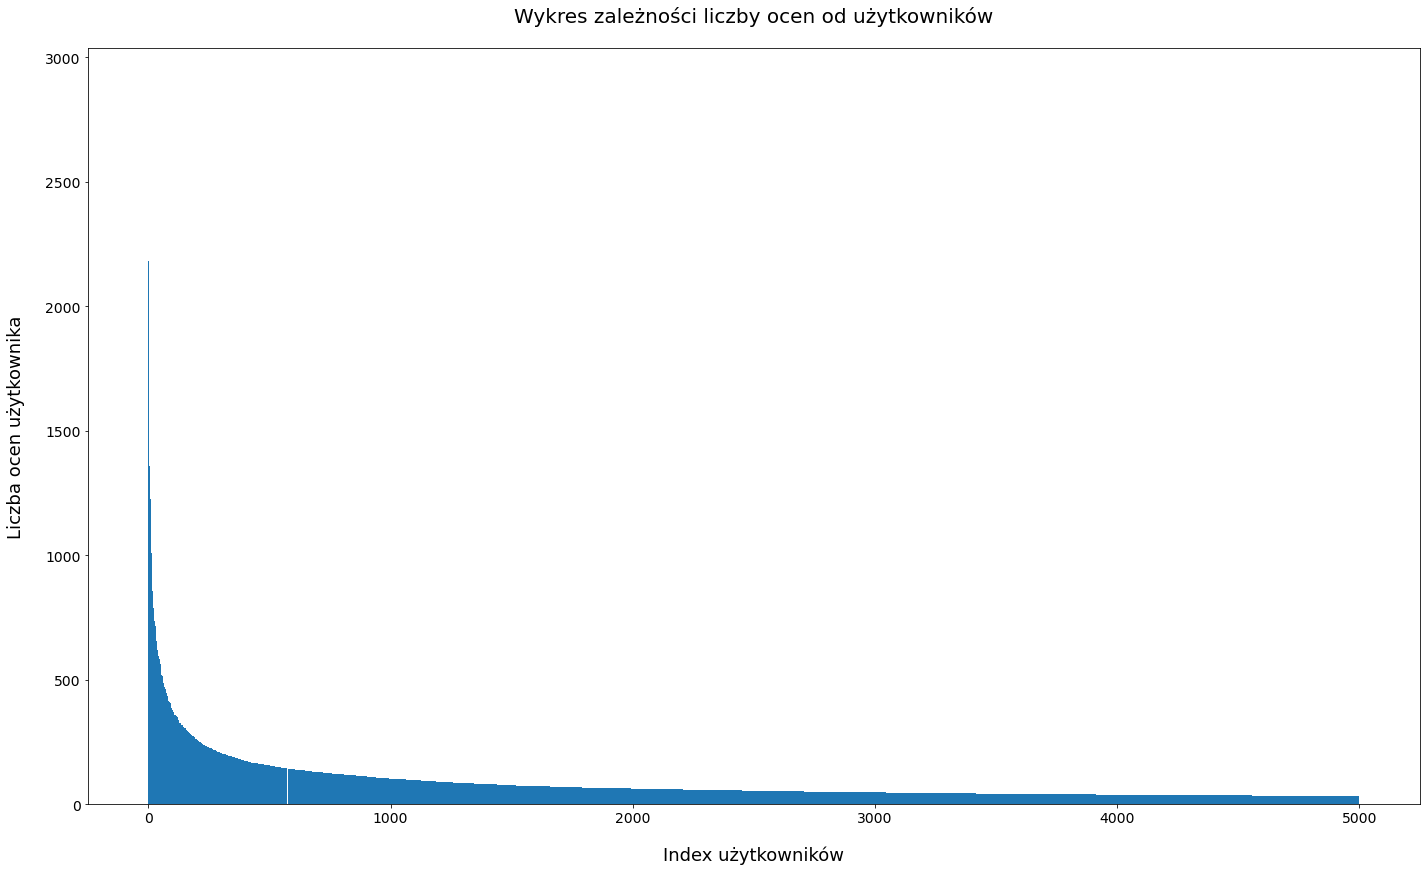

In [65]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.rcParams['axes.titlepad'] = 20
ax = fig.add_axes([0,0,1,1])

ax.bar(ids, y, width=1.0)
ax.set_ylabel("Liczba ocen użytkownika", fontsize=18, labelpad=20)
ax.set_xlabel("Index użytkowników", fontsize=18, labelpad=20)
ax.set_title("Wykres zależności liczby ocen od użytkowników", fontsize=20, y=1.008)


plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
# plt.tight_layout()
plt.show()

# fig.savefig('G:/Recipes/Wykresy/long_tail_users.png', dpi=100)

## Liczba ocen / przepis

In [66]:
y = list(ratings_per_recipe['Count'])[:5000]
ids = range(0, len(y))

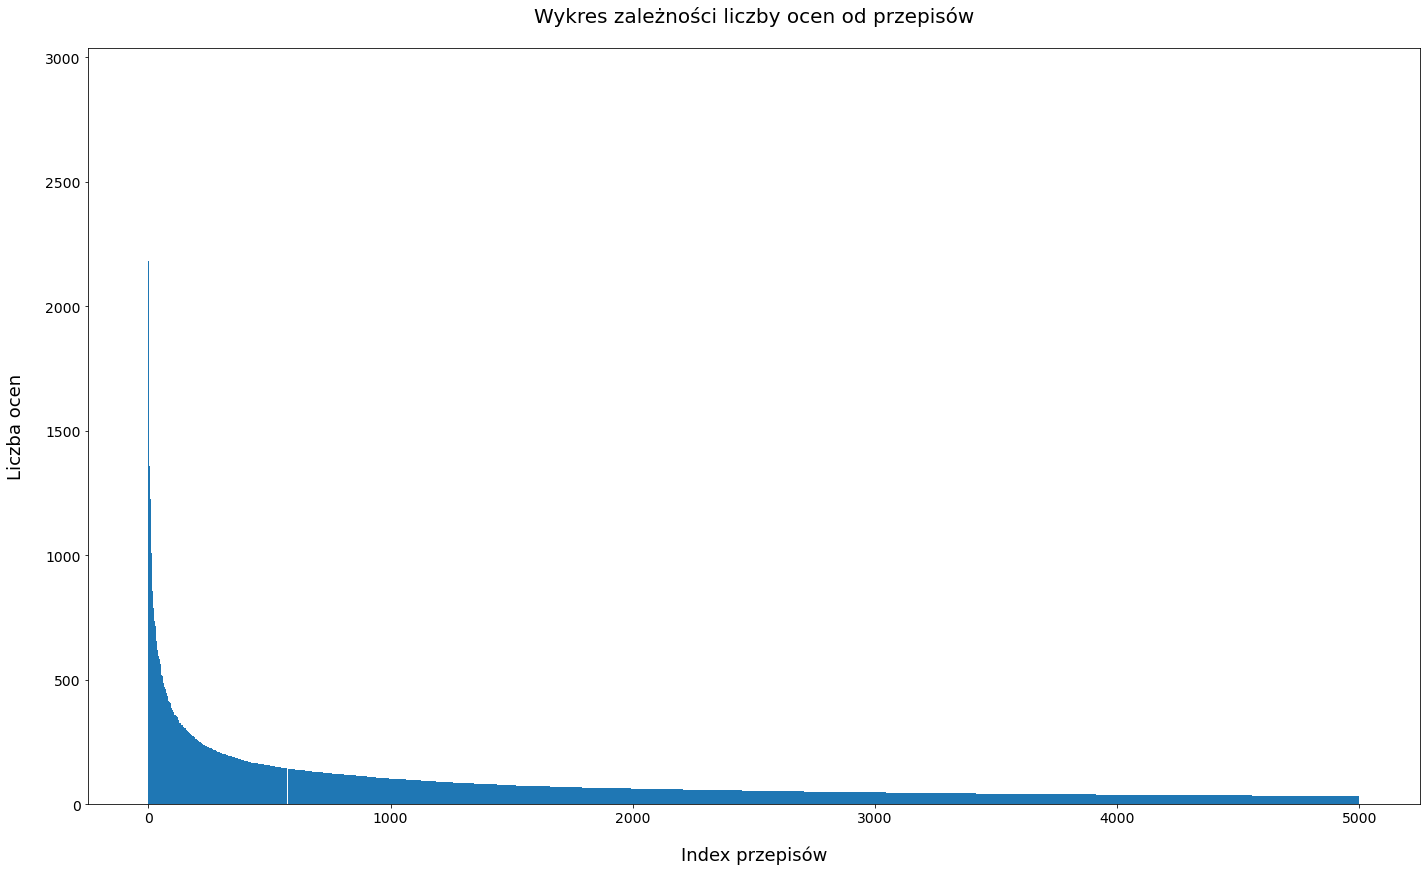

In [68]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.rcParams['axes.titlepad'] = 20

ax = fig.add_axes([0,0,1,1])

ax.bar(ids, y, width=1.0)
ax.set_ylabel("Liczba ocen", fontsize=18, labelpad=20)
ax.set_xlabel("Index przepisów", fontsize=18, labelpad=20)
ax.set_title("Wykres zależności liczby ocen od przepisów", fontsize=20, y=1.008)

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

plt.show()

# fig.savefig('../Data/IMG/ratings_counts_per_user.png', dpi=100)

"Long tail problem" - większość itemów w systemie jest oceniona tylko przez kilku użytkowników. Większość użytkowników ma zaledwie kilka ocen.

# Czas

In [45]:
ratings_time['Month'] = ratings_time['DateSubmitted'].apply(lambda x: x.month)
ratings_time['Year'] = ratings_time['DateSubmitted'].apply(lambda x: x.year)
ratings_time['DayOfWeek'] = ratings_time['DateSubmitted'].apply(lambda x: x.weekday)
ratings_time['IsWeekend'] = ratings_time['DayOfWeek'].apply(lambda x: x > 5)
ratings_time['Quarter'] = ratings_time['DateSubmitted'].apply(lambda x: x.quarter)

In [46]:
ratings_per_month = ratings_time.groupby('Month').agg({'Month': 'count'})
ratings_per_month = ratings_per_month.rename(columns={'Month': 'Count'})

## Liczba ocen w zależności od miesiąca

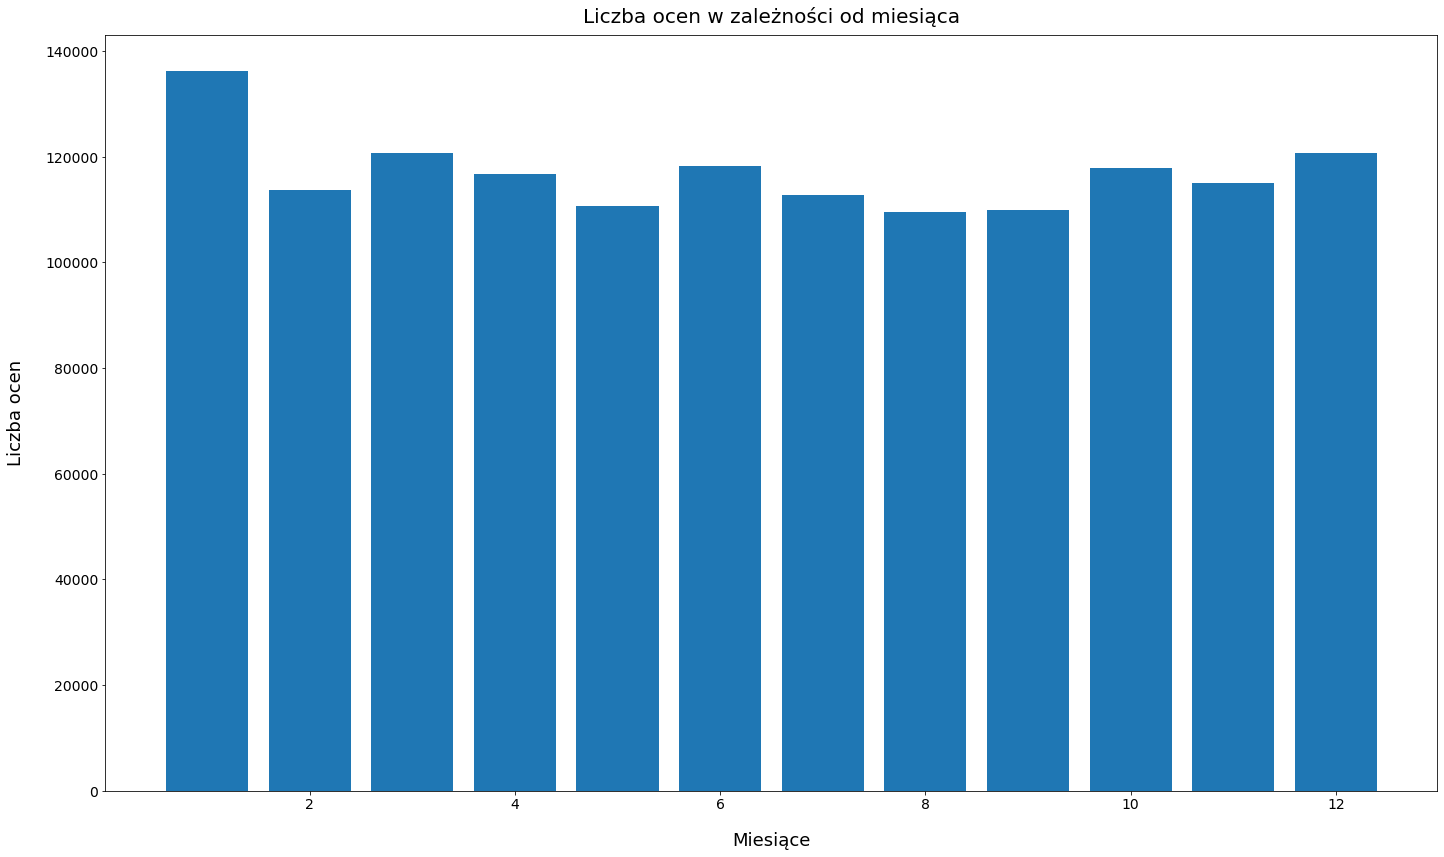

In [47]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
ax = fig.add_axes([0,0,1,1])

plt.bar(ratings_per_month.index, ratings_per_month['Count'])
ax.set_ylabel('Liczba ocen', fontsize=18, labelpad=20)
ax.set_xlabel('Miesiące', fontsize=18, labelpad=20)
ax.set_title("Liczba ocen w zależności od miesiąca", fontsize=20, y=1.008)


plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

plt.show()

# fig.savefig('../Data/IMG/ratings_counts_per_month.png', dpi=100)

## Rozkład ocen w zależności od miesiąca

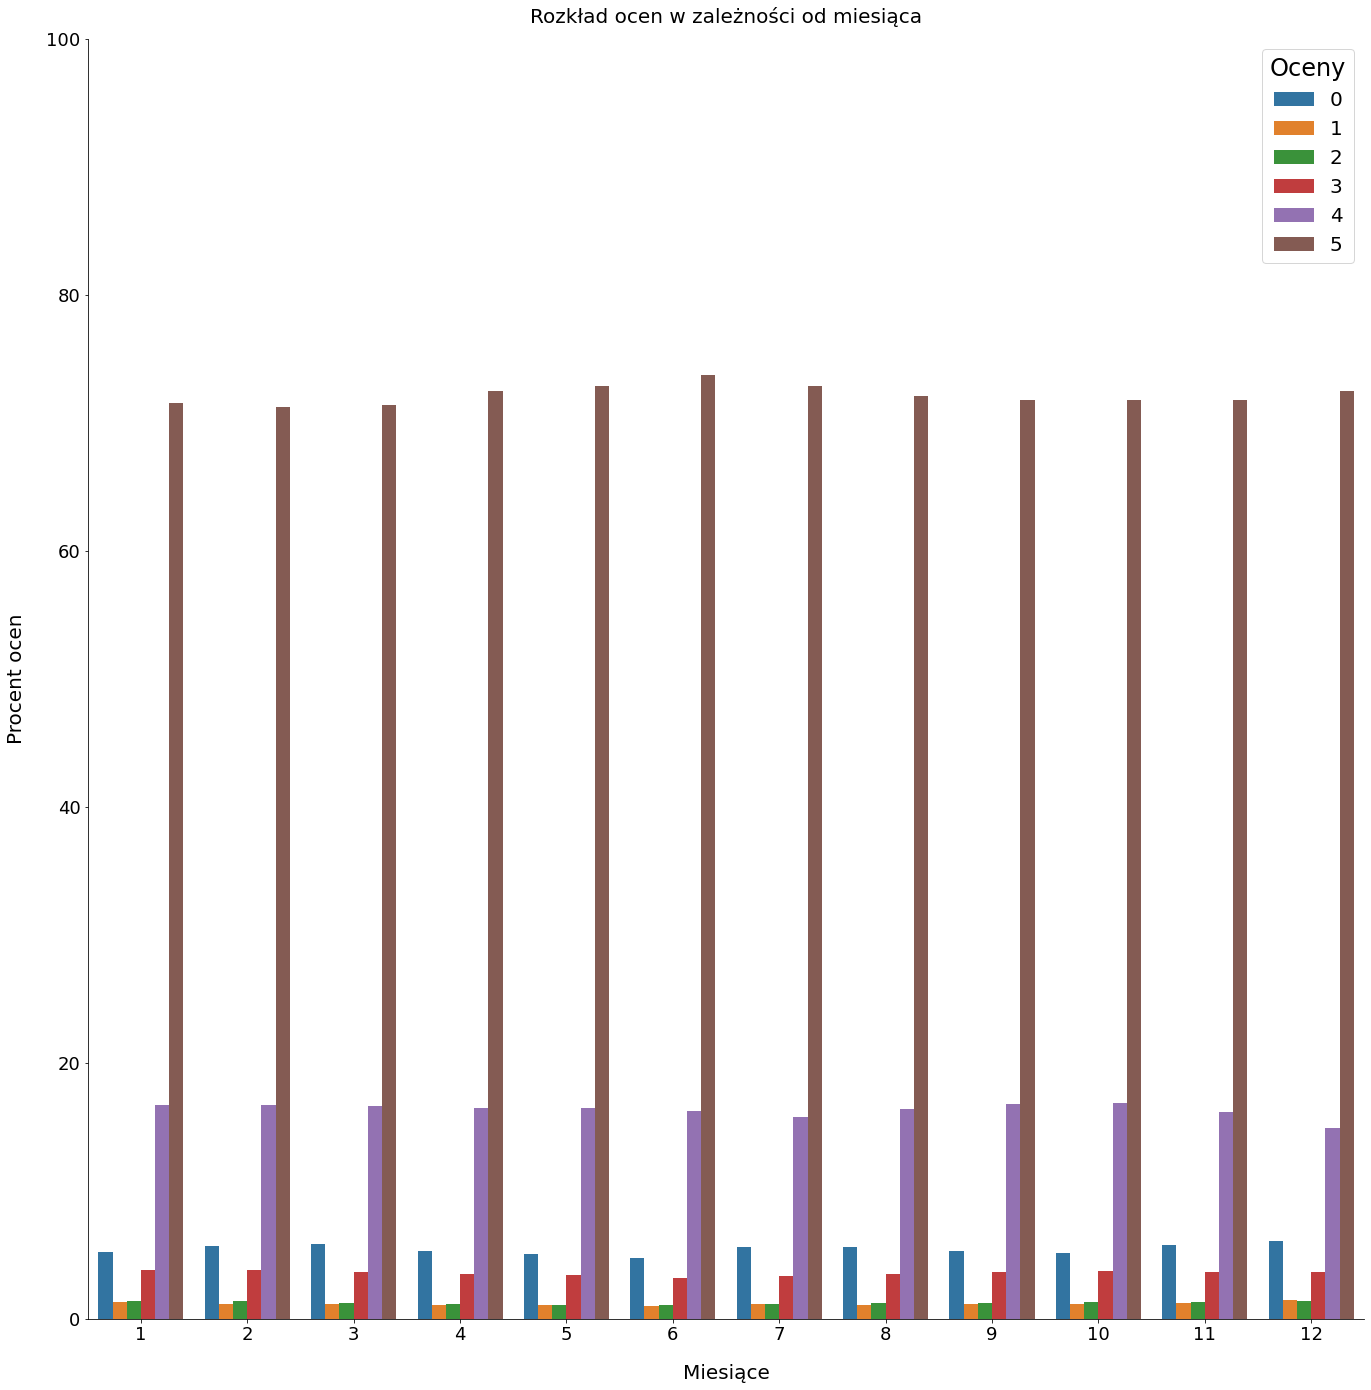

In [48]:
x,y = 'Month', 'Rating'


df1 = ratings_time.groupby(x)[y].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('percent').reset_index()

g = sns.catplot(x=x,y='percent',hue=y,kind='bar',data=df1, height=18.5, legend=False)
g.ax.set_ylim(0,100)

g.ax.set_ylabel('Procent ocen', fontsize=20, labelpad=20)
g.ax.set_xlabel('Miesiące', fontsize=20, labelpad=20)
g.ax.set_title("Rozkład ocen w zależności od miesiąca", fontsize=20, y=1.008)
plt.legend(title='Oceny', fontsize='20', title_fontsize='24')

plt.yticks(fontsize=18)
plt.xticks(fontsize=18)

plt.show()

# fig.savefig('../Data/IMG/ratings_dist_per_month.png', dpi=100)

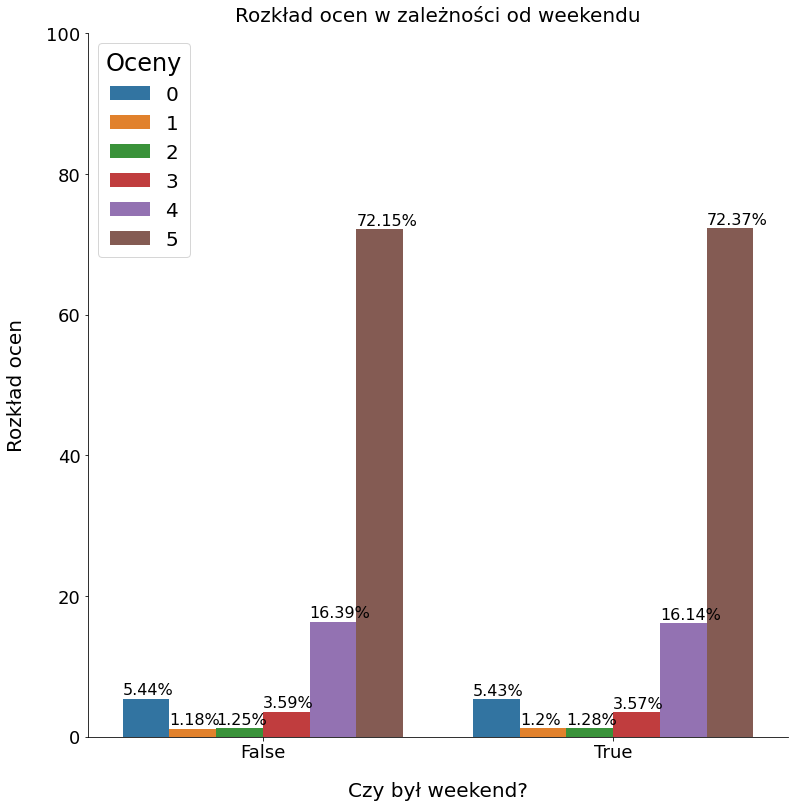

In [49]:
x,y = 'IsWeekend', 'Rating'

df1 = ratings_time.groupby(x)[y].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('percent').reset_index()

g = sns.catplot(x=x,y='percent',hue=y,kind='bar',data=df1, legend=False, height=10.5)
g.ax.set_ylim(0,100)

g.ax.set_ylabel('Rozkład ocen', fontsize=20, labelpad=20)
g.ax.set_xlabel('Czy był weekend?', fontsize=20, labelpad=20)
g.ax.set_title("Rozkład ocen w zależności od weekendu", fontsize=20, y=1.008)
plt.legend(title='Oceny', fontsize='20', title_fontsize='24')

plt.yticks(fontsize=18)
plt.xticks(fontsize=18)

for p in g.ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y+0.5,txt, fontsize=16)
    
plt.show()
# fig.savefig('../Data/IMG/ratings_dist_per_month.png', dpi=100)

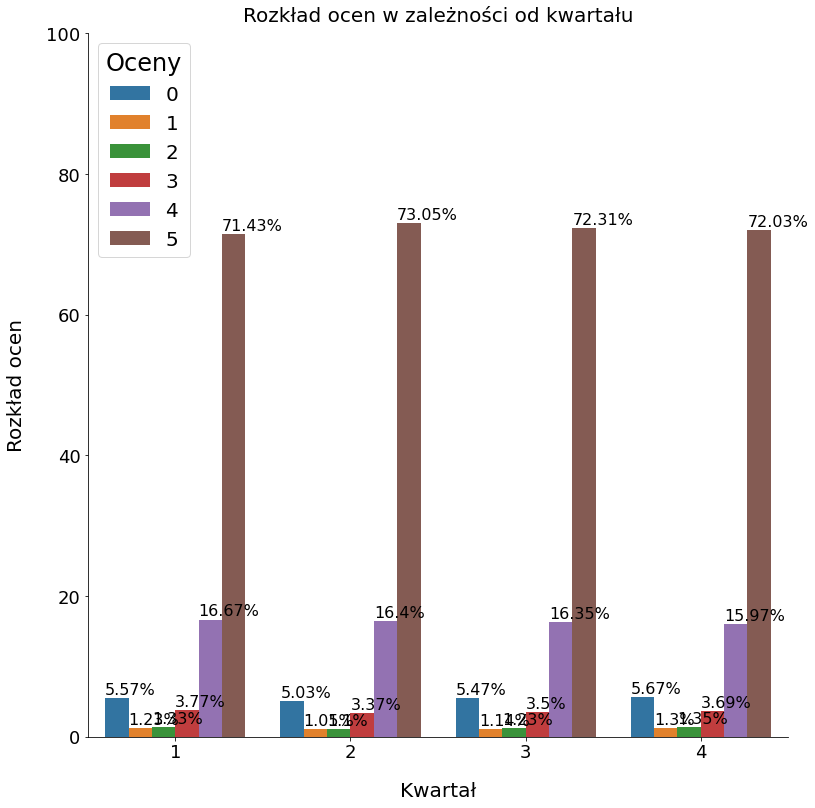

In [50]:
x,y = 'Quarter', 'Rating'

df1 = ratings_time.groupby(x)[y].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('percent').reset_index()


g = sns.catplot(x=x,y='percent',hue=y,kind='bar',data=df1, legend=False, height=10.5)
g.ax.set_ylim(0,100)

g.ax.set_ylabel('Rozkład ocen', fontsize=20, labelpad=20)
g.ax.set_xlabel('Kwartał', fontsize=20, labelpad=20)
g.ax.set_title("Rozkład ocen w zależności od kwartału", fontsize=20, y=1.008)
plt.legend(title='Oceny', fontsize='20', title_fontsize='24')

plt.yticks(fontsize=18)
plt.xticks(fontsize=18)

for p in g.ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y+0.5,txt, fontsize=16)
    
plt.show()
# fig.savefig('../Data/IMG/ratings_dist_per_quarter.png', dpi=100)

Rozkład ocen jest taki sam dla różnych przedziałów czasu, więc taka informacja raczej nie będzie miała wpływu na oceny. 

# Categories

In [52]:
for counts, values in recipes_desc.RecipeCategory.value_counts().items():
    print(counts, values)

Dessert 62072
Lunch/Snacks 32586
One Dish Meal 31345
Vegetable 27231
Breakfast 21101
Beverages 16076
Chicken 13249
Meat 13131
Breads 12804
Pork 12603
Sauces 12166
Chicken Breast 11282
Potato 10870
Quick Breads 10387
< 60 Mins 9719
< 30 Mins 9020
Cheese 8462
Pie 7775
Bar Cookie 7029
Low Protein 6663
< 15 Mins 6662
Drop Cookies 6385
Stew 5679
Yeast Breads 5523
Beans 5463
Candy 5229
Salad Dressings 5066
< 4 Hours 4969
Frozen Desserts 4804
Spreads 4694
Poultry 3925
Cheesecake 3915
Low Cholesterol 3807
European 3690
Smoothies 3562
Very Low Carbs 3386
Steak 3242
Onions 3177
Savory Pies 3055
Curries 2828
Rice 2735
Fruit 2568
Chowders 2331
Grains 2280
Corn 2274
Yam/Sweet Potato 2238
Asian 2196
Crab 2171
Punch Beverage 2169
Mexican 2119
Lamb/Sheep 2050
Spinach 1960
Spaghetti 1865
Chicken Thigh & Leg 1739
Healthy 1720
Ham 1614
Roast Beef 1522
Greens 1514
Whole Chicken 1475
Clear Soup 1474
Tarts 1456
Gelatin 1435
Tuna 1413
Peppers 1412
Cauliflower 1398
Weeknight 1337
Black Beans 1325
Apple 1287
S

# Save data

In [ ]:
import pickle
# with open(INDEX_TO_RECIPE_OBJ, 'wb') as pickle_file:
#      pickle.dump(index_to_recipe, pickle_file)
# with open(RECIPE_ID_TO_NAME, 'wb') as pickle_file:
#      pickle.dump(recipe_id_to_name, pickle_file)
# with open(RECIPE_ID_TO_CAT, 'wb') as pickle_file:
#      pickle.dump(recipe_id_to_cat, pickle_file)
# with open(RECIPE_TO_INDEX_OBJ, 'wb') as pickle_file:
#      pickle.dump(recipe_to_index, pickle_file)
# with open(REVIEWS_PER_RECIPE_WITH_0, 'wb') as pickle_file:
#      pickle.dump(reviews_per_recipe_with_0, pickle_file)
# with open(REVIEWS_PER_RECIPE_WITHOUT_0, 'wb') as pickle_file:
#      pickle.dump(reviews_per_recipe_without_0, pickle_file)
# with open(REVIEWS_PER_USER_WITH_0, 'wb') as pickle_file:
#      pickle.dump(reviews_per_user_with_0, pickle_file)
# with open(REVIEWS_PER_USER_WITHOUT_0, 'wb') as pickle_file:
#      pickle.dump(reviews_per_user_without_0, pickle_file)
# recipes_small.to_parquet(RECIPES_SMALL)
# ratings_small.to_parquet(RATINGS_SMALL)
# ratings_time.to_parquet(RATINGS_TIME)


# with open(RECIPE_ID_TO_INGREDIENTS, 'wb') as pickle_file:
#      pickle.dump(recipe_id_to_ing, pickle_file)

In [ ]:

# recipes_with_ratings.to_parquet("../samples/recipes_with_ratings.parquet")      
# with open("../samples/index_to_recipe_with_ratings.obj", 'wb') as pickle_file:
#      pickle.dump(index_to_recipe_with_ratings, pickle_file)
        
# with open("../samples/recipe_to_index_with_ratings.obj", 'wb') as pickle_file:
#      pickle.dump(recipe_to_index_with_ratings, pickle_file)